In [1]:
import pandas as pd
from pandasql import sqldf
import boto3
import json
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os
from geopy.distance import distance
import numpy as np
from sklearn.preprocessing import Normalizer
from keras import models, layers
from sklearn.model_selection import train_test_split
%run '../extra_fns.ipynb'
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
with open('../config.json') as json_data:
    config = json.load(json_data)

In [3]:
s3 = boto3.client(
    's3',
    aws_access_key_id=config['boto']['aws_access_key_id'],
    aws_secret_access_key=config['boto']['aws_secret_access_key']
)

In [4]:
model_dir = 'trained_models'
try:
    os.makedirs(model_dir)
except Exception as e:
    print(e)

[Errno 17] File exists: 'trained_models'


In [5]:
callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=1),
    ModelCheckpoint(filepath=model_dir + '/basic_model.h5', monitor='val_loss', save_best_only=True)
]

In [6]:
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
train_file = data_dir + '/train.csv'
test_file = data_dir + '/test.csv'

# s3.upload_file(src_file, boto_config['buckets']['kaggle'], src_file)
# s3.upload_file(src_file_cleaned, boto_config['buckets']['kaggle'], src_file_cleaned)

# s3.download_file(boto_config['buckets']['kaggle'], src_file, src_file)
# s3.download_file(boto_config['buckets']['kaggle'], src_file_cleaned, src_file_cleaned)

# train = pd.read_csv(train_file)
# test = pd.read_csv(test_file)

In [7]:
# train['distance'] = train.apply(lambda row : int(distance(
#     (row['pickup_latitude'], row['pickup_longitude']),
#     (row['dropoff_latitude'], row['dropoff_longitude'])).m), axis=1)

# train.pickup_datetime = pd.to_datetime(train.pickup_datetime)

# train['pickup_monthday'] = train.pickup_datetime.dt.day
# train['pickup_weekday'] = train.pickup_datetime.dt.weekday
# train['pickup_hour'] = train.pickup_datetime.dt.hour

In [8]:
# test['distance'] = test.apply(lambda row : int(distance(
#     (row['pickup_latitude'], row['pickup_longitude']),
#     (row['dropoff_latitude'], row['dropoff_longitude'])).m), axis=1)

# test.pickup_datetime = pd.to_datetime(test.pickup_datetime)

# test['pickup_monthday'] = test.pickup_datetime.dt.day
# test['pickup_weekday'] = test.pickup_datetime.dt.weekday
# test['pickup_hour'] = test.pickup_datetime.dt.hour

In [9]:
# train.to_csv('./data/train-clean.csv')
# test.to_csv('./data/test-clean.csv')

train = pd.read_csv('./data/train-clean.csv')
test = pd.read_csv('./data/test-clean.csv')

# Prediction

In [11]:
y_train = np.array(train.trip_duration)
X_train = np.array(train.loc[:, ['passenger_count', 'distance', 'pickup_monthday', 'pickup_weekday', 'pickup_hour', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_test = np.array(test.loc[:, ['passenger_count', 'distance', 'pickup_monthday', 'pickup_weekday', 'pickup_hour', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

In [13]:
nml = Normalizer()

X_train = nml.fit_transform(X_train)
X_val = nml.transform(X_val)
X_test = nml.transform(X_test)

In [22]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

model.summary()

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=512,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________
Train on

Min Val Absolute Error 407.38754559163755 on Epoch 3


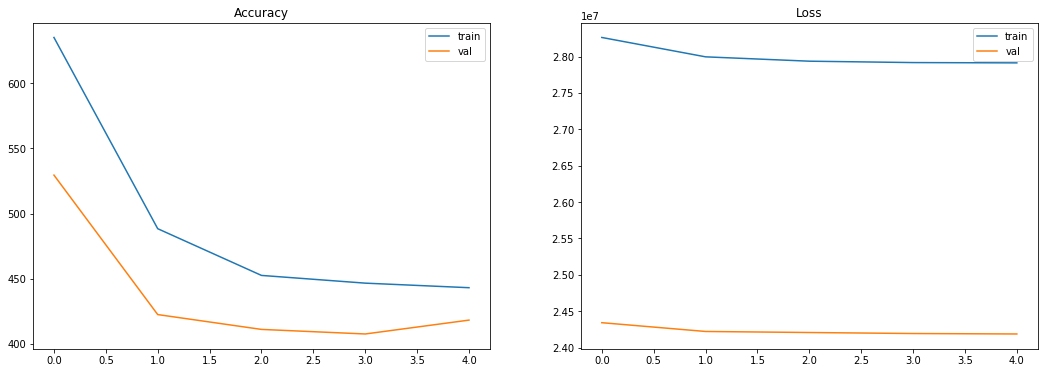

In [23]:
results = history.history
epochs = history.epoch

print('Min Val Absolute Error {0} on Epoch {1}'.format(np.min(results['val_mean_absolute_error']), np.argmin(results['val_mean_absolute_error'])))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

ax1.plot(epochs, results['mean_absolute_error'], label='train')
ax1.plot(epochs, results['val_mean_absolute_error'], label='val')
ax1.set_title('Accuracy')
# ax1.set_ylim([0, 1])
ax1.legend()

ax2.plot(epochs, results['loss'], label='train')
ax2.plot(epochs, results['val_loss'], label='val')
ax2.set_title('Loss')
ax2.legend()

plt.show()

In [24]:
model = models.load_model(model_dir + '/basic_model.h5')

In [25]:
predictions = model.predict(X_test).astype(int)

subs = pd.DataFrame()
subs['id'] = test.id
subs['trip_duration'] = predictions

subs.to_csv(data_dir + '/subs.csv', index=False) # 0.59 in kaggle

# Geocluster

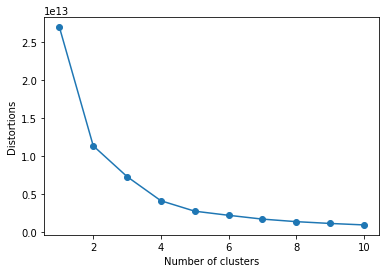

In [29]:
distortions = []

for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init = 'k-means++', 
                n_init = 10,
                max_iter = 300,
                random_state = 1)
    
    km.fit(train.loc[:, ['pickup_latitude', 'pickup_longitude']])
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.show()

In [37]:
i = 8
km = KMeans(n_clusters=i,
            init = 'k-means++', 
            n_init = 10,
            max_iter = 300,
            random_state = 1)

train['pickup_cl'] = km.fit_predict(train.loc[:, ['pickup_latitude', 'pickup_longitude']])
train['dropoff_cl'] = km.predict(train.loc[:, ['dropoff_latitude', 'dropoff_longitude']])
test['pickup_cl'] = km.predict(test.loc[:, ['pickup_latitude', 'pickup_longitude']])
test['dropoff_cl'] = km.predict(test.loc[:, ['dropoff_latitude', 'dropoff_longitude']])


In [38]:
y_train = np.array(train.trip_duration)
X_train = np.array(train.loc[:, ['passenger_count', 'distance', 'pickup_monthday', 'pickup_weekday', 'pickup_hour', 'pickup_cl', 'dropoff_cl']])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_test = np.array(test.loc[:, ['passenger_count', 'distance', 'pickup_monthday', 'pickup_weekday', 'pickup_hour', 'pickup_cl', 'dropoff_cl']])

In [39]:
nml = Normalizer()

X_train = nml.fit_transform(X_train)
X_val = nml.transform(X_val)
X_test = nml.transform(X_test)

In [42]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

model.summary()

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=512,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________
Train on

Min Val Absolute Error 438.82750076405824 on Epoch 7


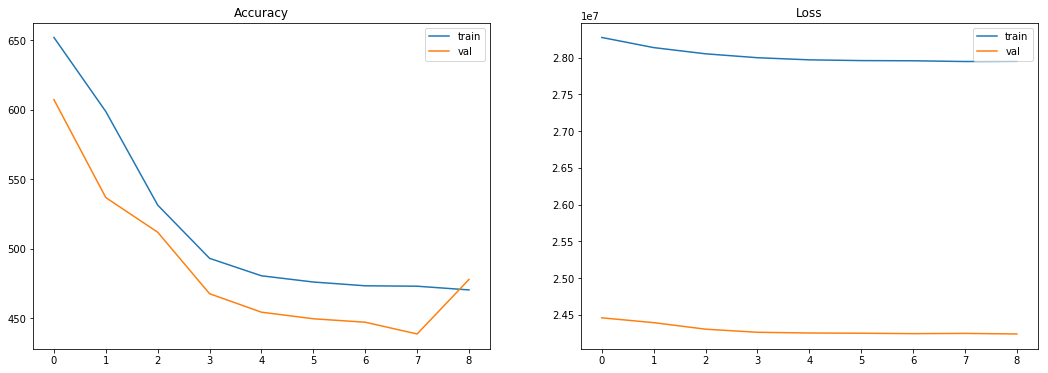

In [43]:
results = history.history
epochs = history.epoch

print('Min Val Absolute Error {0} on Epoch {1}'.format(np.min(results['val_mean_absolute_error']), np.argmin(results['val_mean_absolute_error'])))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

ax1.plot(epochs, results['mean_absolute_error'], label='train')
ax1.plot(epochs, results['val_mean_absolute_error'], label='val')
ax1.set_title('Accuracy')
# ax1.set_ylim([0, 1])
ax1.legend()

ax2.plot(epochs, results['loss'], label='train')
ax2.plot(epochs, results['val_loss'], label='val')
ax2.set_title('Loss')
ax2.legend()

plt.show()

In [44]:
predictions = model.predict(X_test).astype(int)

subs = pd.DataFrame()
subs['id'] = test.id
subs['trip_duration'] = predictions

subs.to_csv(data_dir + '/subs.csv', index=False) # 0.64 in kaggle